# Mini-Project 1 - Used Cars in the USA - SVM & LR Classification
#### By: David Wei, Sophia Wu, Dhruba Dey, Queena Wang

## Introduction
In this section we will continue using our used car dataset and be building out a classification model using Logistic Regression (LR), Support Vector Machines (SVM) and then optimizing these models using SGD (Stochastic Gradient Descent). In the following sections we have split up these areas into the following points:
1. Data Tidying
2. Data Transformations
3. Feature Select & Dimensionality Reduction
4. Logistic Regression
5. SVM
6. Optimization for LR and SVM
7. Analyzing and Intepretations of LR, SVM, and SGD Models
8. Conclusions

In [1]:
#importing libraries and reading in file
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') #ignoring warnings
import missingno as msno

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine.data import economics
from plotnine import ggplot, aes, geom_line

#general sklearn libraries
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
import ptitprince as pt
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler #for scaling

#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score

For convenience and clarity, we have exported all of the data tidying and cleaning we have applied to our original dataset from our initial EDA workbook as an importable file. This will allow us to simply pick up on where we left off without cluttering our notebook with all prior code. For reference, please refer to the following [github link](https://github.com/chee154/ml-Py-used_cars/blob/main/Used_Car_Lab_1_DataVisualization.ipynb) where all work has been contained.

In [2]:
#df_raw = pd.read_csv('data/finaldata.csv')
#df_raw = pd.read_csv('C:/ml-Py-used_cars/data/kaggle_used_cars_data.csv')
df_raw = pd.read_csv(r'E:\Data Files\used_cars_data_cleaned.csv')
print('# of Records: '+str(len(df_raw)))
print('# of Columns: '+str(df_raw.shape[1]))

# of Records: 697989
# of Columns: 18


## Data Tidying

#### Addressing Empty Values
<b>NOTE</b>: First time running the logistic regression model returned an error: 
<br>
*ValueError: Input contains NaN, infinity or a value too large for dtype('float64').*
<br>
Therefore, we will fix this by once again removing any strangling NA records from our dataset.

In [3]:
df_cleaned = df_raw.copy()
df_cleaned = df_cleaned.dropna()
print(len(df_cleaned))
print('# of Records Removed: '+str(len(df_raw)-len(df_cleaned)))

697881
# of Records Removed: 108


#### Cleaning up final dataframe
After the initial EDA, we will make the appropriate adjustments to our dataset based on our findings. To begin, let's get look at the relationship between **'length'** and **'height'** due to it's high correlation.

In [4]:
df_test = df_cleaned.copy()
print(df_test.shape[1])

if df_test['length'].equals(df_test['height']) == True:
    print('they are the same... dropping one')
    df_test = df_test.drop(columns='height')
    print(df_test.shape[1])
else: 
    print('they are not the same')

18
they are the same... dropping one
17


## Data Transformations for Modeling

#### IntegerEncoding
Once the data has been imported and cleaned, we will work on transforming our dataset to be more useful for our classification models. To start we will first one-hot encode all of our categorical (object) datatypes as numbers.

In [5]:
def number_encode_features(df):
    result = df_cleaned.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object or result.dtypes[column]==np.bool:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    print('Columns converted: '+str(encoders))
    return result

Below shows a snap shot of what the final data looks like after categorical data has been encoded.
You can see the body type is in a numerical representation, instead of a string (object) type, before being encoded.
<br>
- Below shows a snap shot of what the final data looks like after categorical data has been encoded.
- You can see the body type is in a numerical representation, instead of a string (object) type, before being encoded.

In [6]:
encoded_data = number_encode_features(df_cleaned)
encoded_data

Columns converted: {'body_type': LabelEncoder(), 'frame_damaged': LabelEncoder(), 'has_accidents': LabelEncoder(), 'is_new': LabelEncoder()}


,body_type,city_fuel_economy,daysonmarket,engine_displacement,frame_damaged,has_accidents,height,highway_fuel_economy,horsepower,is_new,length,maximum_seating,mileage,owner_count,price,seller_rating,width,year
0,6,27.0,55,1500.0,0,0,57.6,36.0,160.0,0,57.6,5.0,42394.0,1.0,14639.0,3.447761,73.0,2018
1,1,18.0,36,3500.0,0,0,55.1,24.0,311.0,0,55.1,4.0,62251.0,1.0,32000.0,2.800000,81.5,2018
2,5,18.0,27,3600.0,0,0,70.7,27.0,310.0,0,70.7,8.0,36410.0,1.0,23723.0,3.447761,78.6,2018
3,5,15.0,27,3600.0,0,1,69.9,22.0,281.0,0,69.9,8.0,36055.0,1.0,22422.0,3.447761,78.5,2017
4,5,18.0,24,3600.0,0,0,69.3,25.0,295.0,0,69.3,5.0,25745.0,1.0,29424.0,3.447761,84.8,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697984,5,26.0,32,1400.0,0,0,66.0,31.0,138.0,0,66.0,5.0,7444.0,1.0,17836.0,4.533333,69.9,2019
697985,5,26.0,17,2500.0,0,0,66.4,32.0,170.0,0,66.4,5.0,20160.0,1.0,20700.0,4.333333,80.0,2017
697986,6,26.0,17,2500.0,0,0,57.9,37.0,179.0,0,57.9,5.0,62138.0,1.0,17700.0,4.333333,72.0,2018
697987,4,18.0,89,3500.0,0,0,70.6,23.0,278.0,0,70.6,5.0,20009.0,1.0,40993.0,5.000000,75.2,2017


Referncing our transformed variable 'price_group' as an int to it's original string value for future analysis and interpretation

Now we are ready for some model building!

In [7]:
df_final = encoded_data.copy()
print('# of Records: '+str(len(df_final)))
print('# of Columns: '+str(df_final.shape[1]))
print()
print(df_final.dtypes)

# of Records: 697881
# of Columns: 18

body_type                 int32
city_fuel_economy       float64
daysonmarket              int64
engine_displacement     float64
frame_damaged             int64
has_accidents             int64
height                  float64
highway_fuel_economy    float64
horsepower              float64
is_new                    int64
length                  float64
maximum_seating         float64
mileage                 float64
owner_count             float64
price                   float64
seller_rating           float64
width                   float64
year                      int64
dtype: object


In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

## Feature Selection & Dimensionality Reduction

#### Running PCA for data reduction

In [8]:
# creating the data containing numberical dataset
df_num = df_final[['city_fuel_economy','daysonmarket','engine_displacement', 'highway_fuel_economy','horsepower',
                 'length', 'maximum_seating','mileage','owner_count','price','seller_rating','width','year']]
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697881 entries, 0 to 697988
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   city_fuel_economy     697881 non-null  float64
 1   daysonmarket          697881 non-null  int64  
 2   engine_displacement   697881 non-null  float64
 3   highway_fuel_economy  697881 non-null  float64
 4   horsepower            697881 non-null  float64
 5   length                697881 non-null  float64
 6   maximum_seating       697881 non-null  float64
 7   mileage               697881 non-null  float64
 8   owner_count           697881 non-null  float64
 9   price                 697881 non-null  float64
 10  seller_rating         697881 non-null  float64
 11  width                 697881 non-null  float64
 12  year                  697881 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 74.5 MB


In [9]:
names = np.array(['city_fuel_economy','daysonmarket','engine_displacement', 'highway_fuel_economy','horsepower', 
		'length', 'maximum_seating','mileage','owner_count','price','seller_rating','width','year'])
features_names = pd.Series(names)

In [10]:
from sklearn.decomposition import PCA
# Standardize the feature
df_num= StandardScaler().fit_transform(df_num)

pca = PCA(n_components=6)
df_num_pca = pca.fit(df_num).transform(df_num) # fit data and then transform it

# print the components
print ('pca:', pca.components_.transpose())

pca: [[-0.42132195  0.10484459 -0.07575576  0.0349237  -0.03502952  0.10394236]
 [ 0.00816961  0.03943551  0.15608508  0.75987378  0.62174468 -0.08615542]
 [ 0.38779046 -0.05961322  0.13399639 -0.13894031  0.06548041 -0.3597012 ]
 [-0.42033337  0.07322847 -0.00547019  0.01545757 -0.01530633  0.13395932]
 [ 0.39796295  0.06143529  0.28372849 -0.13368919  0.06310181 -0.00394776]
 [ 0.34893888  0.01828504 -0.3868652   0.11651535 -0.07347132 -0.02218401]
 [ 0.25013437 -0.0014054  -0.58073668  0.21767071 -0.10117483 -0.06927466]
 [ 0.0327452  -0.56342485 -0.08415367  0.03716664 -0.0411177  -0.03164666]
 [ 0.01446323 -0.46640452  0.23161095 -0.04082692  0.10577622  0.42763984]
 [ 0.22155206  0.32639307  0.41670299 -0.13676347  0.0571755   0.06396686]
 [ 0.035765   -0.00095536  0.35810053  0.53601347 -0.75518429 -0.07311398]
 [ 0.3177215   0.07822123 -0.08443861  0.11803659 -0.03713884  0.79029352]
 [-0.00816067  0.57165816 -0.12148744  0.00203441 -0.01540709  0.10610315]]


In [11]:
# the explained variance indicates how much information (variance) can be attributed to each of the principal components
pca.explained_variance_ratio_
Sum = sum(pca.explained_variance_ratio_) 
print(pca.explained_variance_ratio_)
print(Sum*100) ## first 6 components explains 84.3% of the variation 

[0.36999273 0.18842452 0.08495619 0.07847443 0.07452814 0.04641989]
84.27959007026332


In [12]:
pca = PCA(n_components=3)
df_num_pca = pca.fit(df_num).transform(df_num) # fit data and then transform it

# print the components
print ('pca:', pca.components_.transpose())

pca: [[-0.42132195  0.10484459 -0.07575576]
 [ 0.00816961  0.03943551  0.15608508]
 [ 0.38779046 -0.05961322  0.13399639]
 [-0.42033337  0.07322847 -0.00547019]
 [ 0.39796295  0.06143529  0.28372849]
 [ 0.34893888  0.01828504 -0.3868652 ]
 [ 0.25013437 -0.0014054  -0.58073668]
 [ 0.0327452  -0.56342485 -0.08415367]
 [ 0.01446323 -0.46640452  0.23161095]
 [ 0.22155206  0.32639307  0.41670299]
 [ 0.035765   -0.00095536  0.35810053]
 [ 0.3177215   0.07822123 -0.08443861]
 [-0.00816067  0.57165816 -0.12148744]]


In [13]:
# the explained variance indicates how much information (variance) can be attributed to each of the principal components
pca.explained_variance_ratio_
Sum = sum(pca.explained_variance_ratio_) 
print(pca.explained_variance_ratio_)
print(Sum*100) ## first 3 components explains 64.3% of the variation 

[0.36999273 0.18842452 0.08495619]
64.33734354838782


In [14]:
# find the weights of the features in the 6 two components

def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array

# assign weights with features
pca_weight_strings = get_feature_names_from_weights(pca.components_, features_names)
pca_weight_strings

['-0.42*city_fuel_ec +0.01*daysonm +0.39*engine_displac -0.42*highway_fuel_ec +0.40*horse +0.35*l +0.25*maximum_se +0.03*mi +0.01*owner_ +0.22* +0.04*seller_r +0.32* -0.01* ',
 '0.10*city_fuel_ec +0.04*daysonm -0.06*engine_displac +0.07*highway_fuel_ec +0.06*horse +0.02*l -0.00*maximum_se -0.56*mi -0.47*owner_ +0.33* -0.00*seller_r +0.08* +0.57* ',
 '-0.08*city_fuel_ec +0.16*daysonm +0.13*engine_displac -0.01*highway_fuel_ec +0.28*horse -0.39*l -0.58*maximum_se -0.08*mi +0.23*owner_ +0.42* +0.36*seller_r -0.08* -0.12* ']

The top 7 Principal Component explains 84% variation of the data, whereas the top 3 does 65%. Though we have built our models using the full dataset including categorical variables, we would like to see which numerical dimensions have contributed much to the top 3 PCs and use those numerical dimensions to build the model and evaluate the different matrix such accuracy, recall and so forth. In this analysis, we use 0.3 as the cut-off coefficient of linear combinations of PC1, PC2 and PC3 to demarcate the significance of the features in these Principal Components. We have found that 'has_accidents','city_fuel_economy','engine_displacement', 'highway_fuel_economy','horsepower','length','mileage','owner_count','price','width','year' contribute meaningfully in top 3 PCs. 

After running dimensionality reduction by using PCA (after standardization) we will utilize the following coefficients:
1. city_fuel_economy
2. engine_displacement
3. highway_fuel_economy
4. horsepower
5. length
6. mileage
7. owner_count
8. price
9. width
10. year

In [151]:
df_pca= df_final[['has_accidents','city_fuel_economy','engine_displacement', 'highway_fuel_economy','horsepower','length','mileage','owner_count','price','width','year']].copy()
df_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697881 entries, 0 to 697988
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   has_accidents         697881 non-null  int64  
 1   city_fuel_economy     697881 non-null  float64
 2   engine_displacement   697881 non-null  float64
 3   highway_fuel_economy  697881 non-null  float64
 4   horsepower            697881 non-null  float64
 5   length                697881 non-null  float64
 6   mileage               697881 non-null  float64
 7   owner_count           697881 non-null  float64
 8   price                 697881 non-null  float64
 9   width                 697881 non-null  float64
 10  year                  697881 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 63.9 MB


Initially when we ran our SVM model, with roughly 700k records it took around 4 hours to run without completing, so we decided to create a new dataset with only 30k records to implement SVM models

In [152]:
 # Convert the dictionary into DataFrame  
df_pca_small = pd.DataFrame(df_pca) 
# Randomly select 1000 rows for test
df_pca_small=df_pca_small.sample(n=30000) 
df_pca_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 381899 to 12036
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   has_accidents         30000 non-null  int64  
 1   city_fuel_economy     30000 non-null  float64
 2   engine_displacement   30000 non-null  float64
 3   highway_fuel_economy  30000 non-null  float64
 4   horsepower            30000 non-null  float64
 5   length                30000 non-null  float64
 6   mileage               30000 non-null  float64
 7   owner_count           30000 non-null  float64
 8   price                 30000 non-null  float64
 9   width                 30000 non-null  float64
 10  year                  30000 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 2.7 MB


## Training and Testing Split
Once our dataset ready for modeling, we will move on to our next steps of splitting up our data. For our dataset, we will use a 80:20 split that roughly leaves our full training set with roughly 560k records and test set the remaining 140k records. We will then apply a 3-fold Cross Validation with a seed of 42 because it (42) is the answer to the ultimate question of life, the universe, and everything.
<br><br>
Additionally, we will also create another training/test split with a random sample of 30k records with all the same split parameters to use on our SVM model since running it on the entire 700k dataset was taking too long (4+ hours without finishing) to compile.
<br><br>
Our resposne variable will be 'has_accidents', which in it's rawest form a boolean value ('T', 'F') that tells us whether a car has been in an accident or not.

#### Train/Test Split on 700k dataset

In [153]:
if 'has_accidents' in df_pca:
    y = df_pca['has_accidents'].values # get the labels we want
    del df_pca['has_accidents'] # get rid of the class label
    X = df_pca.values # use everything else to predict!

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size= 0.2)     
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


#### Train/Test Split on 30k dataset

In [154]:
if 'has_accidents' in df_pca_small:
    y_small = df_pca_small['has_accidents'].values # get the labels we want
    del df_pca_small['has_accidents'] # get rid of the class label
    X_small = df_pca_small.values # use everything else to predict!

num_cv_iterations_small = 3
num_instances_small = len(y_small)
cv_object_small = ShuffleSplit(n_splits=num_cv_iterations_small,test_size= 0.2)     
print(cv_object_small)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


## Logistic Regression (LR)
Once the training and test set was built, we next ran our Logistic Regression (LR) model using L2 penalization and a regularization ("c") value of 1. With 3 fold CV, we saw that each of our testing iterations returned an average accuracy of about .876 with the lowest accuracy of 0.875 and the highest accuracy of 0.881.

In [155]:
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) 

In [156]:
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.8786332991825301
confusion matrix
 [[122565    117]
 [ 16823     72]]
====Iteration 1  ====
accuracy 0.8793425850963984
confusion matrix
 [[122690    110]
 [ 16731     46]]
====Iteration 2  ====
accuracy 0.8779311777728422
confusion matrix
 [[122463    132]
 [ 16906     76]]


In [130]:
print(X_train.shape[0])
print(X_test.shape[0])

558304
139577


**Weights *before* normalization:**
<br>
We can see that before we normalized our model coefficients the **'horsepower'** was the only coefficient that had a somewhat positive weight whereas all other coefficients were negative with **'year'** being the lowest negative coefficient. It's strange to see horsepower hold the highest weight in the unnormalized model but this could simply be because both horsepwoer and year have vastly different scales as shown by their median values. 

In [131]:
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_pca.columns
zip_vars = zip(lr_clf.coef_.T,df_pca.columns) # combine attributes
zip_vars = sorted(zip_vars)

for coef, name in zip_vars:
    print(name, 'has weight of', coef[0])

year has weight of -0.0009553779250896197
length has weight of -0.0004542463325083729
width has weight of -0.0004119454733101234
price has weight of -3.4591969267793524e-05
city_fuel_economy has weight of -2.7186942712450248e-05
engine_displacement has weight of 1.7480282842966055e-06
mileage has weight of 7.722467215652182e-06
highway_fuel_economy has weight of 8.923425580866553e-05
owner_count has weight of 0.00014250053759082165
horsepower has weight of 0.0015011722404617701


In [132]:
print(df_pca[['horsepower']].median())
print(df_pca[['year']].median())

horsepower    248.0
dtype: float64
year    2017.0
dtype: float64


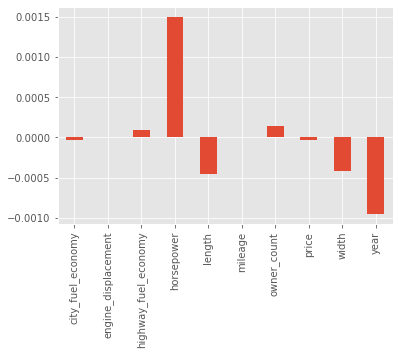

In [133]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df_pca.columns)
weights.plot(kind='bar')
plt.show()

**Weights *after* normalization:**
<br>
Once the weights have been normalized, a different picture is shown. Not only do our model's accuracy slightly increase (by .004), but the weights of our models make much more sense. 
<br><br>
We can see that as expected, **'mileage'** is heavily weighted along with **'highway_fuel_economy'**. This makes sense since mileage is simply a metric of how much a car has driven; the more miles on a car, the more it's been driven, thus the more it's driven the higher chances it has of being involved in an accident. **'owner_count'** is also positively weighted since different owners can increase the odds of accidents as 1 owner may be a conservative driver whereas the next owner may not. 
<br><br>
What's interesting is that **'price'** has a very strong negative weight with the odds of having an accident, which can be explained that the more often a car has an accident, the lower the car's price will be.

In [135]:
df_pca['mileage'].corr(df_pca['owner_count'])

0.4904807719458635

In [136]:
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

accuracy: 0.8792351175336911
[[122608    162]
 [ 16694    113]]


In [137]:
# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_pca.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

price has weight of -0.3985271437293967
city_fuel_economy has weight of -0.09960716815995434
year has weight of -0.08956638559161825
width has weight of -0.0661191529595463
engine_displacement has weight of -0.032228315467299935
length has weight of 0.032258568841670505
owner_count has weight of 0.10772461531820561
highway_fuel_economy has weight of 0.13923525214450205
horsepower has weight of 0.14606566260302206
mileage has weight of 0.20556430761891398


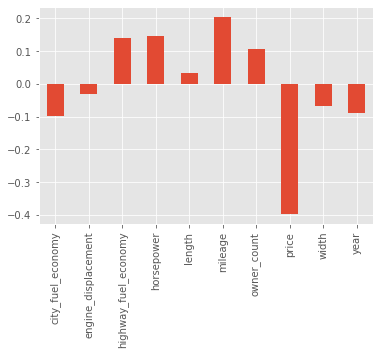

In [138]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df_pca.columns)
weights.plot(kind='bar')
plt.show()

## Support Vector Machines (SVM)

#### Model 1 - Running SVM

In [157]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object_small.split(X_small,y_small): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_small = X[train_indices]
    y_train_small = y[train_indices]
    
    X_test_small = X[test_indices]
    y_test_small = y[test_indices]
    
X_train_scaled_small = scl_obj.transform(X_train_small) # apply to training
X_test_scaled_small = scl_obj.transform(X_test_small) 

In [144]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC


# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled_small, y_train_small)  # train object

y_hat_small = svm_clf.predict(X_test_scaled_small) # get test set precitions

acc = mt.accuracy_score(y_test_small,y_hat_small)
conf = mt.confusion_matrix(y_test_small,y_hat_small)
print('accuracy:', acc )
print(conf)

accuracy: 0.8593333333333333
[[5156    0]
 [ 844    0]]


In [146]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_pca_small.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['has_accidents'] = y_small[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df_pca_small['has_accidents'] = y_small # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8754 entries, 480418 to 322562
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city_fuel_economy     8754 non-null   float64
 1   engine_displacement   8754 non-null   float64
 2   highway_fuel_economy  8754 non-null   float64
 3   horsepower            8754 non-null   float64
 4   length                8754 non-null   float64
 5   mileage               8754 non-null   float64
 6   owner_count           8754 non-null   float64
 7   price                 8754 non-null   float64
 8   width                 8754 non-null   float64
 9   year                  8754 non-null   int64  
 10  has_accidents         8754 non-null   int64  
dtypes: float64(9), int64(2)
memory usage: 820.7 KB


These plots illustrate the difference between the original distributions of price, mileage, horsepower and width and the distributions of the same dataset derived for support vector machine of test data. We can see the distributions of the price and the mileage closely match between the original data and those we got from test data of support vector machine, the fact that indicates that these two dimensions clearly classify the response variables in terms of no-accidents vs has_accidents. However, the horsepower and the width have done the reasonable job in classify the response variable as the distributions of original data and those of support vector are close, though not as close as what the price and the mileage have done. 
<br><br>
The finding confirms the PCA analysis where we could see the mileage and the price bear the maximum correlation with PC1 and PC2, which explain 65% of the variation. Secondly, the correlations / weights of the price and the mileage in the logistic regression model is much higher than others, meaning these two dimensions play an emphatic role in the classifying the response variable. 


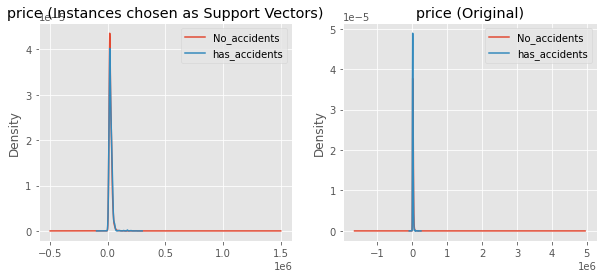

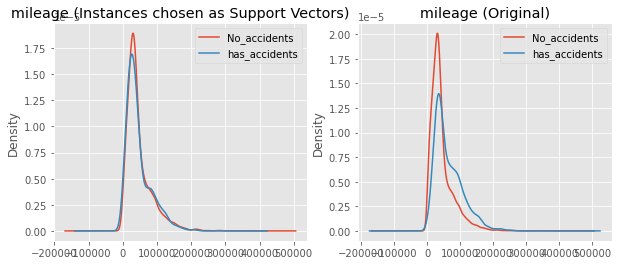

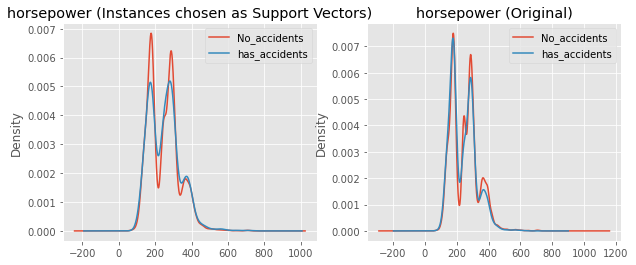

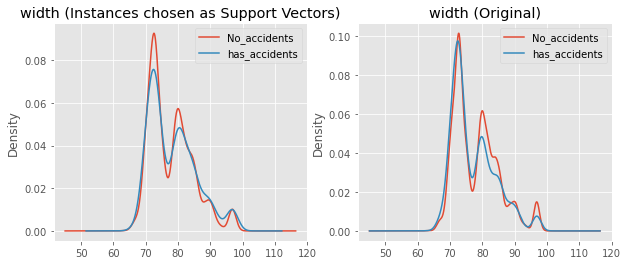

In [147]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['has_accidents'])
df_grouped = df_pca_small.groupby(['has_accidents'])

# plot KDE of Different variables
vars_to_plot = ['price','mileage','horsepower','width']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['No_accidents','has_accidents'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['No_accidents','has_accidents'])
    plt.title(v+' (Original)')

#### Model 2 - Running SVM using LinearSVC

In [160]:
print(X_train.shape[0])
print(X_train_small.shape[0])

558304
24000


In [161]:
# lets investigate SVMs on the data and play with the parameters and kernels
#from sklearn.svm import SVC
from sklearn.svm import LinearSVC
#Import svm model
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


# import some data to play with
#X, y = make_classification(
#    n_features=18, n_informative=3, n_redundant=0, n_classes=2,
#    n_clusters_per_class=2)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=590000)

# create a svm classifier
svm_clf = svm.LinearSVC() #linear kernel

# train the model using the training sets
svm_clf.fit(X_train, y_train)

# predict the response for test dataset
y_hat = svm_clf.predict(X_test)

# model accuracty : how often is the classifier correct?
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)

Accuracy: 0.8778452037226764
we got a classification rate of 80%, which is considered a decent accuracy"
[[122432    163]
 [ 16887     95]]
For further evaluation, we want ot also check precision and recall of model
Precision 0.3682170542635659
Recall: 0.005594158520786715


In [170]:
print('Accuracy:', acc )
print('we got a classification rate of',round(acc*100,2),'% which is considered a decent accuracy and similar to that of our LR Accuracy')

print("For further evaluation, we want ot also check precision and recall of model")
print("Precision", mt.precision_score(y_test,y_hat))
# Model Recall: what percentage of positive tuples are?
print("Recall:",mt.recall_score(y_test,y_hat))

Accuracy: 0.8778452037226764
we got a classification rate of 87.78 % which is considered a decent accuracy and similar to that of our LR Accuracy
For further evaluation, we want ot also check precision and recall of model
Precision 0.3682170542635659
Recall: 0.005594158520786715


#### Plotting LinearSVC Results

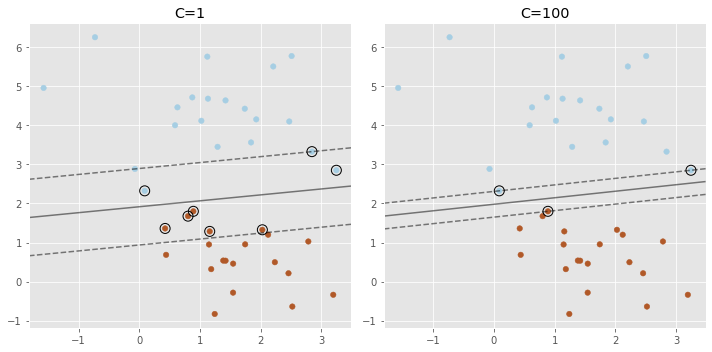

In [171]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=40, centers=2, random_state=0)

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(
        np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
plt.tight_layout()
plt.show()

LinearSVC uses the linear kernel, which optimizes the boundary via linear function. That is the reason it is fast, but many cases it may not yield the most optimized result. LinearSVC applies the loss function to optimize the result. Here, we have used “hinge” (L2 loss function) as the loss function and the default penalty L2. The parameter C is the constraint set to regulate the strength of the regularization, and it is inversely proportional to the strength of regularization, meaning the lower valueof C, the higher the regularization constraint. With the lower restriction, the LinearSVC will try to overfit the model, which is manifested in the C=1 verse C=100.

## Optimization
In this section, we are using SGD, an iterative optimization algorithm, to see if we can improve the accuracy. As indicated below, we tried to run the same dataset with 2 different approaches: (1) linear SVM with SGD classifer (2) Logistic regression with SGD classifer. We are the following “loss” parameter for our SGD classifier function.

 - loss="hinge": (soft-margin) linear Support Vector Machine
 - loss="log": logistic regression
</n>

As a result, we got an accuracy of 87.8% from the SVM with SGD. The accuracy is a slight improvement from our old accuracy 87.7% running only the SVM model.

#### Optimizing Linear SVM Model with SGD Classifier
Here we will try to improve upon our 2nd model (SVM using LinearSVC) by utilizing the SGDClassifier. Our goal with this approach is see how our accuracy changes using SGD classifier. 

In [175]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics as mt

SVM_SGDclf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)

#train the model using the training sets
SVM_SGD_fit = SVM_SGDclf.fit(X_train, y_train)
# predict the response for test dataset
SVM_SGD_y_hat = SVM_SGDclf.predict(X_test)

SVM_SGD_accuracy = mt.accuracy_score(y_test, SVM_SGD_y_hat)
SVM_SGD_conf = mt.confusion_matrix(y_test, SVM_SGD_y_hat)

Accuracy: 0.8783323900069495
we got a classification rate of 87.83323900069495 %


In [176]:
print('Accuracy:', SVM_SGD_accuracy)
print('we got a classification rate of',SVM_SGD_accuracy*100,'%')

Accuracy: 0.8783323900069495
we got a classification rate of 87.83323900069495 %


#### Optimization Logisitic Regression with SGD Classifier

In [177]:
from sklearn.linear_model import SGDClassifier
Logisitic_SGDclf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
from sklearn import metrics as mt

#train the model using the training sets
Logistic_SGD_fit = Logisitic_SGDclf.fit(X_train, y_train)
# predict the response for test dataset
Logistic_SGD_y_hat = Logisitic_SGDclf.predict(X_test)

Logistic_SGD_accuracy = mt.accuracy_score(y_test,Logistic_SGD_y_hat)
Logistic_SGD_conf = mt.confusion_matrix(y_test,Logistic_SGD_y_hat)

In [178]:
print('Accuracy:', Logistic_SGD_accuracy )
print('we got a classification rate of',Logistic_SGD_accuracy*100,'%')

Accuracy: 0.7750775557577538
we got a classification rate of 77.50775557577538 %


By default, we are leveraging the attribute **‘max_iter’**, the maximum number of passes over the training data. The default here is set to 1000. We want to see if there is any influence this parameter has on our accuracy score

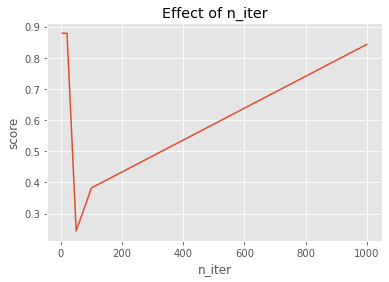

In [179]:
n_iters = [5, 10, 20, 50, 100, 1000]
scores = []
for n_iter in n_iters:
    clf = SGDClassifier(loss="log", penalty="l2", max_iter=n_iter)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_train, y_train))
  
plt.title("Effect of n_iter")
plt.xlabel("n_iter")
plt.ylabel("score")
plt.plot(n_iters, scores) 

Here, we are curious at the performance of the different linear classifiers. Therefore,we decided to run the dataset against all the models.  Based on the diagram  “Effect of loss” showing below . It becomes clear that the **‘log’** and **'squared_hinge'** loss functions gives the best score and the use of the **'modified_huber_loss'** gives the worst value.

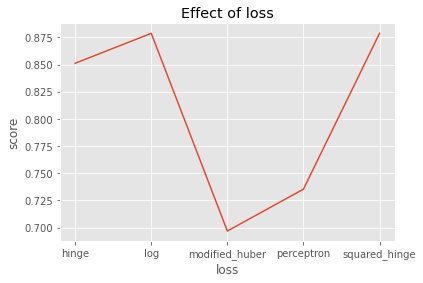

In [180]:
losses = ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"]
scores = []
for loss in losses:
    clf = SGDClassifier(loss=loss, penalty="l2", max_iter=1000)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_train, y_train))
  
plt.title("Effect of loss")
plt.xlabel("loss")
plt.ylabel("score")
x = np.arange(len(losses))
plt.xticks(x, losses)
plt.plot(x, scores) 

## Conclusion

### Model Accuracies (asc order):
- Logistic Regression with SGD: **.775077**
- Support Vector Machine: **.859**
- Logistic Regression (unnormalized): **.875**
- Support Vector Machine with LinearSVC: **.877**
- Linear SVM with SGD: **.87833**
- Logistic Regression (normalized): **.879**

### Model Advantages
1. <u>**Logistic Regression Analysis**</u>:
- **Advantages:** There is less transformation needed in order to make the model return in a reasonable amount of time. Scaler transformation will increase the accuracy, but is not required for performance as the model performs well at scale regardless of whether the data is normalized or not. 
- **Disadvantages:** It’s more difficult to interpretate the model, because the weights is multiplicative and not additive
- **Performance:**There are many different settings that allow the model to have the best possible accuracy. These methods can be iterated with a grid search method. 
- **Time:**cost is low with very large scales and does not suffer with big volume of dataset.

2. <u>**Support Vector Machine Analysis:**</u>
- **Advantages:** Reference from Tan book: They can be easily kernelized to solve nonlinear classification problems.
- **Performance:** the accuracy running the SVM model was neither better nor worse than our other models with an accuracy of 85.9%. However, given the time and the fact that this model was ran using a reduced dataset, our conclusions may have different had we were able to run it with the larger dataset.
- **Disadvantages:** we had to run the SVM model with a reduced dataset since running the SVM model on the entire 700k dataset was taking too long (4+ hours without finishing) to compile. After switching our dataset to 30k, it took a much less time to run.
- **Time:** takes a long time to compile the SVM model without any optimization

3. <u>**Optimization using Stochastic Gradient Descent:**</u>
- **Advantages:** With SGDClassifier it can run much faster than a batch training with faster compile times at a cost of accuracy
- **Disadvantages:** since we are not including all the data, it may not provide us ideal results but. 
- **Performance:** Additionally, overall accuracy could decrease when running multiple iterations due to the directions of the gradient descent in finding the global minima and may eventually diverge. 
- **Time:** Running SGD is actually very computationally fast as comparatively to it's counterpart SVM. Additionally, we have more control in our model parameter constraints that prevent the model from running longer. 

### Final Comments & Conclusions
The linear logistic regression and linear SVMs often yield very similar results. Logistic regression tries to maximize the conditional likelihoods of the training data, which makes it more prone to outliers than SVMs. The SVMs mostly care about the points that are closest to the decision boundary(support vector)- reference from Sebastian Raschka’s Python Machine Learning book. Due to how SVM is modeled, it could potentially have higher acuracies, but since we only ran it on a limited dataset due to compiling issues we were not able to compare apple to apples with our other models in terms of data volume. Overall, the logistic regression model was the quickest to run along with the highest accuracies. 